# Concentration and thickness 

In [11]:
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import matplotlib
matplotlib.interactive(True)
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
from functions import load_ice, trend, find_trends, decomp, gmap
# %matplotlib notebook

In [14]:
def gmap(lon,lat,array,dtrend_95=None, grouping=None, cmap=None, vmin=None, vmax=None):
    '''
    Map with cartopy in monthly or seasonal groups. Inputs are lon, lat, array. Optional arguments: dtrend_95, grouping, cmap, vmin, vmax. Returns a figure. 
    '''
    if dtrend_95 != None:
        hatched = hatch(array, dtrend_95)

    
    # Set up cartopy map      

    #Declare the land and ocean parameters
    LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
    edgecolor='black',
    facecolor=('silver'),
    linewidth=1)
    OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
    facecolor='dimgrey')

    #Declare the lat and lon boundaries for the map and data
    domain = [99, 99, -99, -99]
    domain[0] = np.min(lat) # South
    domain[1] = np.min(lon) # West
    domain[2] = np.max(lat) # North
    domain[3] = np.max(lon) # East
#     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
    domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]


    aoi_map = [domain[0], domain[2], domain[1], domain[3]]
    # Rotation for vertical coast
    rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

    # Plot results
    transform = rot.transform_points(rot,lon,lat)
    x_n = transform[...,0]
    y_n = transform[...,1]
    
    if grouping==None:
        fig = plt.figure(figsize=(10,7),facecolor='white')
        ax = fig.add_subplot(1,1,1, projection=rot)
        ax.add_feature(LAND_highres,zorder=2)
        ax.add_feature(OCEAN_highres,zorder=3)
        ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
        ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
        im = plt.pcolormesh(x_n,y_n,array,transform=ccrs.PlateCarree(),zorder=4,cmap=cmap,vmin=vmin,vmax=vmax)  
        
    if grouping=='monthly':
        fig = plt.figure(figsize=(10,7),facecolor='white')
        months_str = ['January','February','March','April','May','June','July',
                 'August','September','October','November','December']
        # js are here for reordering plots to start from ice season 
        j=8
        for i in range(1,13):
            if j==12:
                j=0
            ax = fig.add_subplot(3, 4, i, projection=rot)
            ax.add_feature(LAND_highres,zorder=2)
            ax.add_feature(OCEAN_highres,zorder=3)
            ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
            ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
            im = plt.pcolormesh(x_n,y_n,array[j,:,:],transform=ccrs.PlateCarree(),zorder=4,cmap=cmap,vmin=vmin,vmax=vmax)  
    #         plt.contourf(x_n,y_n,hatched[j,:,:],levels=1, hatches=['//', ''],  alpha=0.,transform=ccrs.PlateCarree(),zorder=5)
            plt.title(months_str[j])
            j+=1
    
    if grouping=='seasonal':
        fig = plt.figure(figsize=(10,5),facecolor='white')
        season_str = ['Growing (Nov-Jan)', 'Peak (Feb-Apr)', 'Melt (May-Jul)']
        for i in range(len(array)):
            ax = fig.add_subplot(1, 3, i+1, projection=rot)
            ax.add_feature(LAND_highres,zorder=2)
            ax.add_feature(OCEAN_highres,zorder=3)
            ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
            ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
            im = plt.pcolormesh(x_n,y_n,array[i,:,:],transform=ccrs.PlateCarree(),cmap=cmap, zorder=4,vmin=vmin,vmax=vmax)  
#             plt.contourf(x_n,y_n,hatched[i,:,:],levels=1, hatches=['//', ''],  alpha=0.,transform=ccrs.PlateCarree(),zorder=5)
            plt.title(season_str[i])
            i+=1       
        

    fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                        wspace=0.2, hspace=0.2)
 
    return im, fig

# Concentration

In [3]:
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'

In [4]:
lon, lat, juld, CT = load_ice(path,region,'E_CT')

In [5]:
ybar_monthly, ytrend_monthly, dtrend_95_monthly = decomp(lon,lat,juld,CT,'monthly')

2013.4537518024445


In [17]:
ybar_seasonal, ytrend_seasonal, dtrend_95_seasonal = decomp(lon,lat,juld,CT,'seasonal')

1014.4329042434692


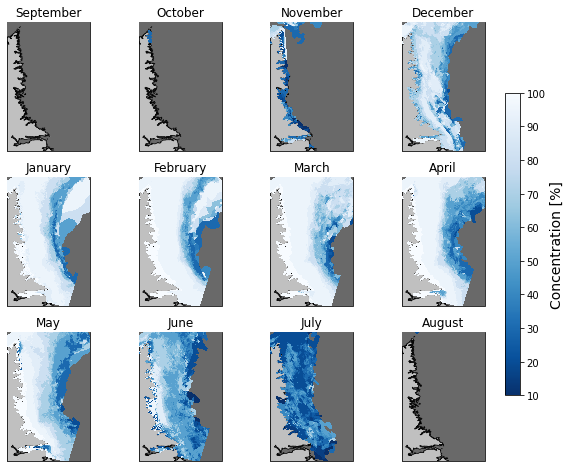

In [13]:
# Seasonal Concentration using median 

im, fig = gmap(lon,lat,ybar_monthly,grouping='monthly',cmap='Blues_r',vmin=10,vmax=100)
cb_ax = fig.add_axes([0.81, 0.16, 0.02, 0.6]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Concentration [%]',fontsize=14)
# plt.savefig('/home/mwang/figures/CT_new.png')

In [18]:
im, fig = gmap(lon,lat,ytrend_seasonal,dtrend_95_seasonal,'seasonal',cmap='RdBu',vmin=-0.02,vmax=0.02)
cb_ax = fig.add_axes([0.81, 0.16, 0.02, 0.6]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Concentration [%]',fontsize=14)
# plt.savefig('/home/mwang/CTtrend_new.png', dpi=200)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Thickness

In [52]:
lon, lat, juld, HA = load_ice(path,region,'E_SA')

In [54]:
ybar_HA_seas, ytrend_HA_seas, dtrend_95_HA_seas = decomp(lon,lat,juld,HA,'seasonal')

771.2729330062866


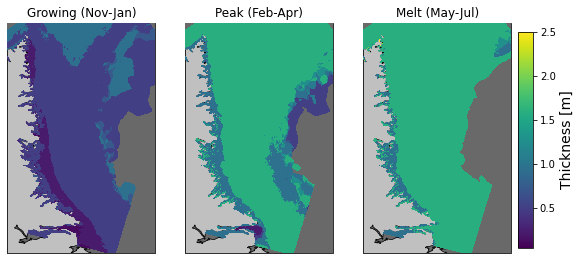

In [57]:
# Seasonal thickness using median

im, fig = mapit(lon,lat,ybar_HA_seas,grouping='seasonal',vmin=0.05,vmax=2.5)
cb_ax = fig.add_axes([0.81, 0.16, 0.02, 0.6]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Thickness [m]',fontsize=14)
# plt.savefig('/home/mwang/seasonal_HA.png')

In [ ]:
im, fig = mapit(lon,lat,ytrend_HA_seas,dtrend_95_HA_seas,'seasonal',cmap='RdBu',vmin=-0.0001,vmax=0.0001)
cb_ax = fig.add_axes([0.82, 0.16, 0.02, 0.6]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Thickness [m]',fontsize=14)
cbar.formatter.set_powerlimits((0, 0))

# plt.savefig('/home/mwang/seasonaltrend_HA.png')

In [ ]:
pickle.loads(first_ice_arr)